In [2]:
import os
os.chdir('..')

import random
import torch

import utils
import utils.dataset_loader
import utils.similarity

import matplotlib
from matplotlib import pyplot as plt

## Settings

In [3]:
clip_name = 'ViT-B/16'
target_name = 'cvcl-resnext'
target_layer = 'vision_encoder.model.layer1,vision_encoder.model.layer2,vision_encoder.model.layer3,vision_encoder.model.layer4'.split(',')
d_probe = 'konk'
# concept_set = 'data/baby_clean_concept.txt'
concept_set = 'data/baby+konk+30k.txt'
batch_size = 128
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [3]:
import importlib
importlib.reload(utils)
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = target_layer, 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/f50eaa0c50a6076a5190b1dd52aeeb6c3e747045/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


All specified layers' activations are already saved.


In [13]:
layer = target_layer[3]
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|██████████| 2048/2048 [00:13<00:00, 147.59it/s]


torch.Size([2048, 30427])


## Visualize Results


 Layer:vision_encoder.model.layer4 Neuron:1458
1st description: yarn, sim:0.070
2nd description: yarns, sim:0.059
3rd description: chenille, sim:0.057
5 most highly activating images in D_probe:


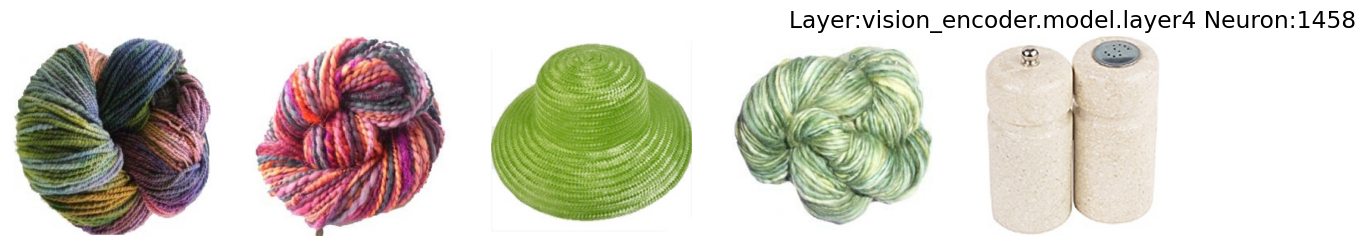


 Layer:vision_encoder.model.layer4 Neuron:192
1st description: eat, sim:0.090
2nd description: kernel, sim:0.090
3rd description: pin, sim:0.089
5 most highly activating images in D_probe:


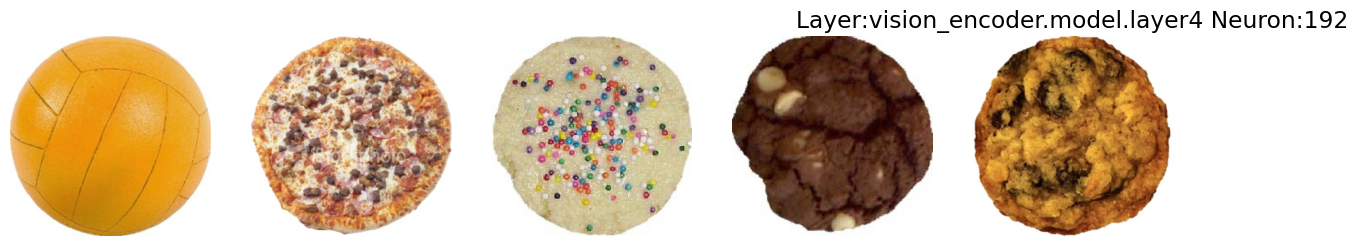


 Layer:vision_encoder.model.layer4 Neuron:305
1st description: rug, sim:0.100
2nd description: rugs, sim:0.087
3rd description: carpets, sim:0.082
5 most highly activating images in D_probe:


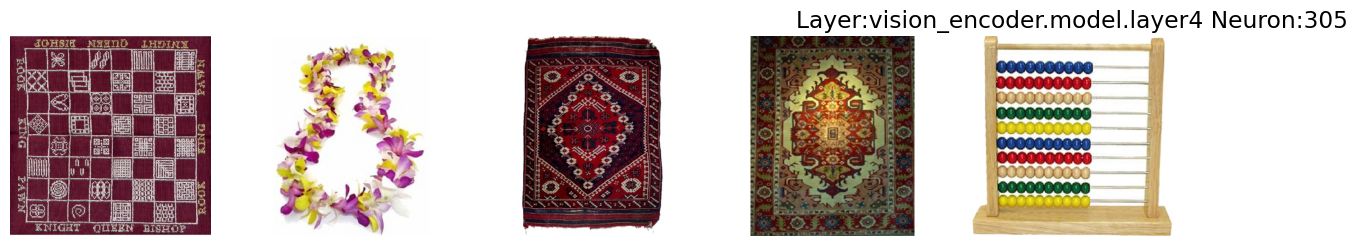


 Layer:vision_encoder.model.layer4 Neuron:857
1st description: honeywell, sim:0.052
2nd description: slinky, sim:0.051
3rd description: msnshopping, sim:0.048
5 most highly activating images in D_probe:


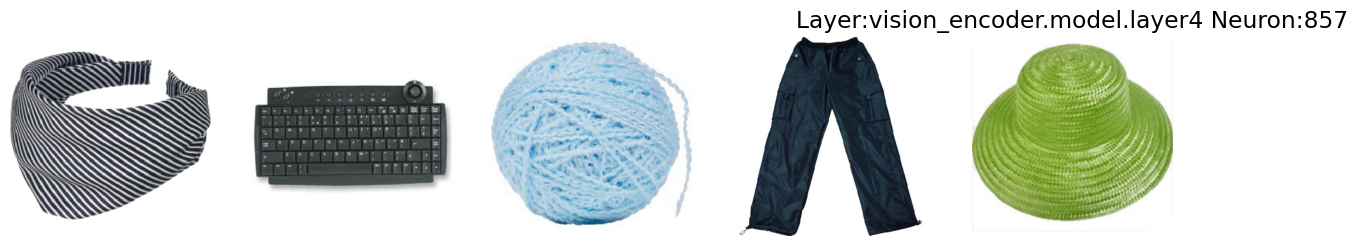


 Layer:vision_encoder.model.layer4 Neuron:293
1st description: yuan, sim:0.094
2nd description: treasury, sim:0.093
3rd description: krona, sim:0.091
5 most highly activating images in D_probe:


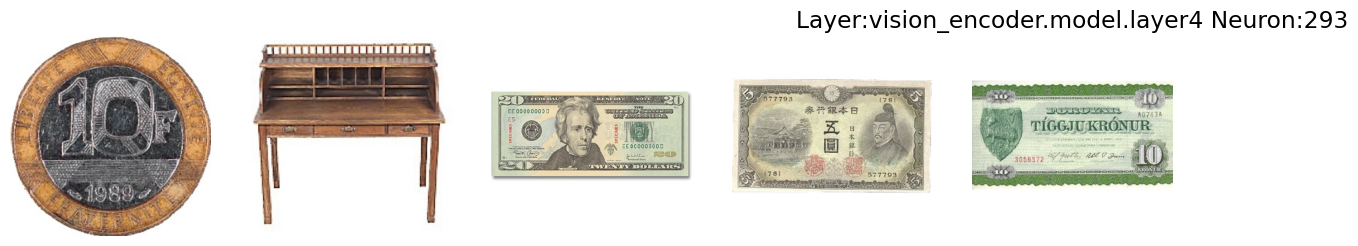


 Layer:vision_encoder.model.layer4 Neuron:1215
1st description: necklace, sim:0.089
2nd description: collier, sim:0.079
3rd description: necklaces, sim:0.073
5 most highly activating images in D_probe:


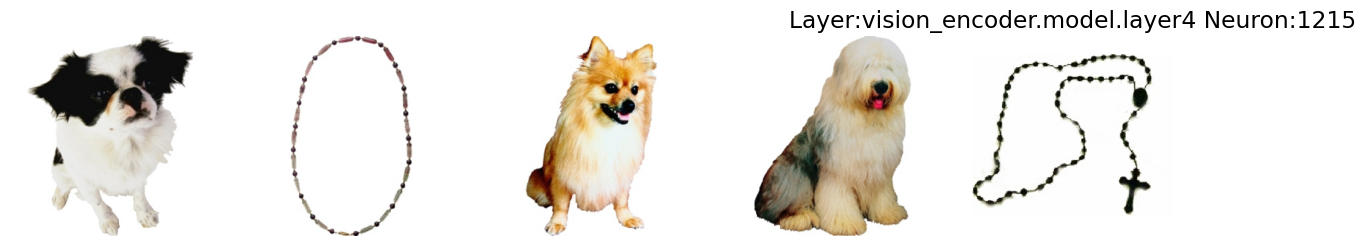


 Layer:vision_encoder.model.layer4 Neuron:1674
1st description: chessboard, sim:0.064
2nd description: checkers, sim:0.053
3rd description: frisbee, sim:0.052
5 most highly activating images in D_probe:


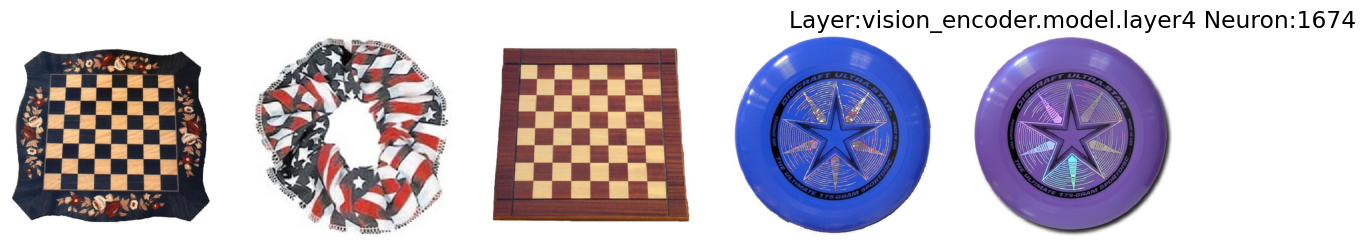


 Layer:vision_encoder.model.layer4 Neuron:520
1st description: sandwich, sim:0.065
2nd description: sandwiches, sim:0.064
3rd description: magazine, sim:0.064
5 most highly activating images in D_probe:


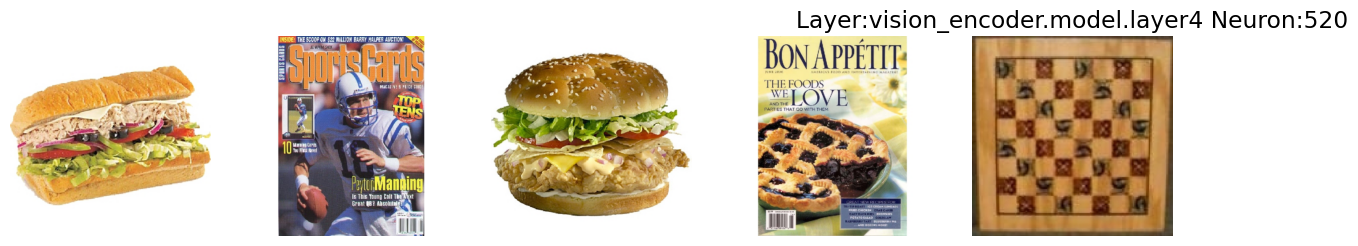


 Layer:vision_encoder.model.layer4 Neuron:17
1st description: microwaves, sim:0.114
2nd description: microwave, sim:0.103
3rd description: monitors, sim:0.093
5 most highly activating images in D_probe:


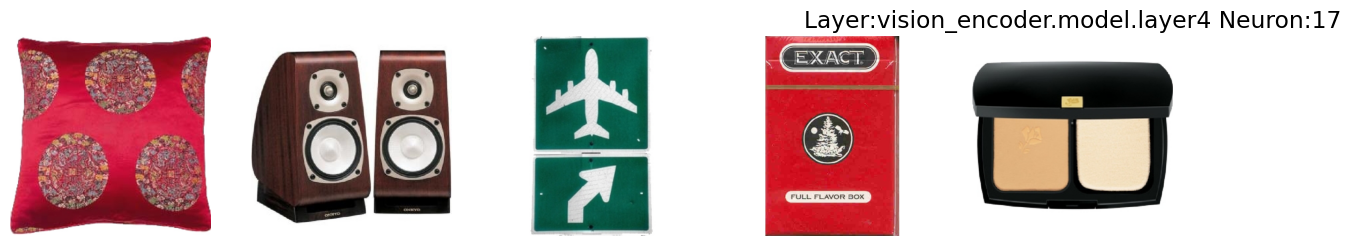


 Layer:vision_encoder.model.layer4 Neuron:136
1st description: chessboard, sim:0.138
2nd description: checkers, sim:0.098
3rd description: chess, sim:0.090
5 most highly activating images in D_probe:


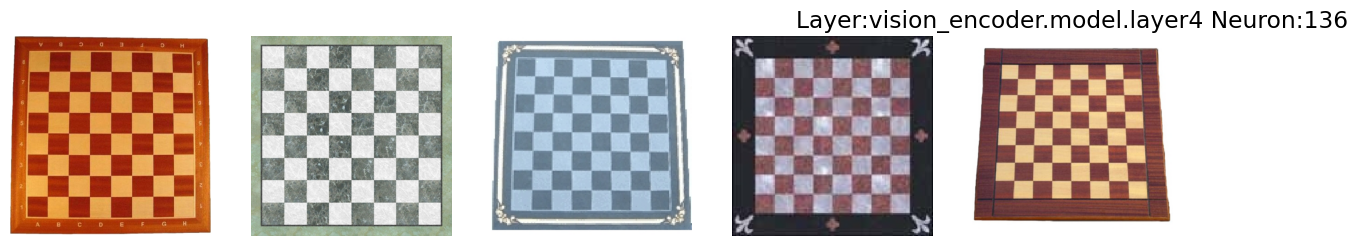

In [14]:
# Random Selected Neurons
neurons_to_check = ids_to_check = random.sample([i for i in range(target_feats.shape[1])], k=10)
#neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]

ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(layer, (int(orig_id))))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(layer, (int(orig_id))))
    plt.show()

Top Similarity Score

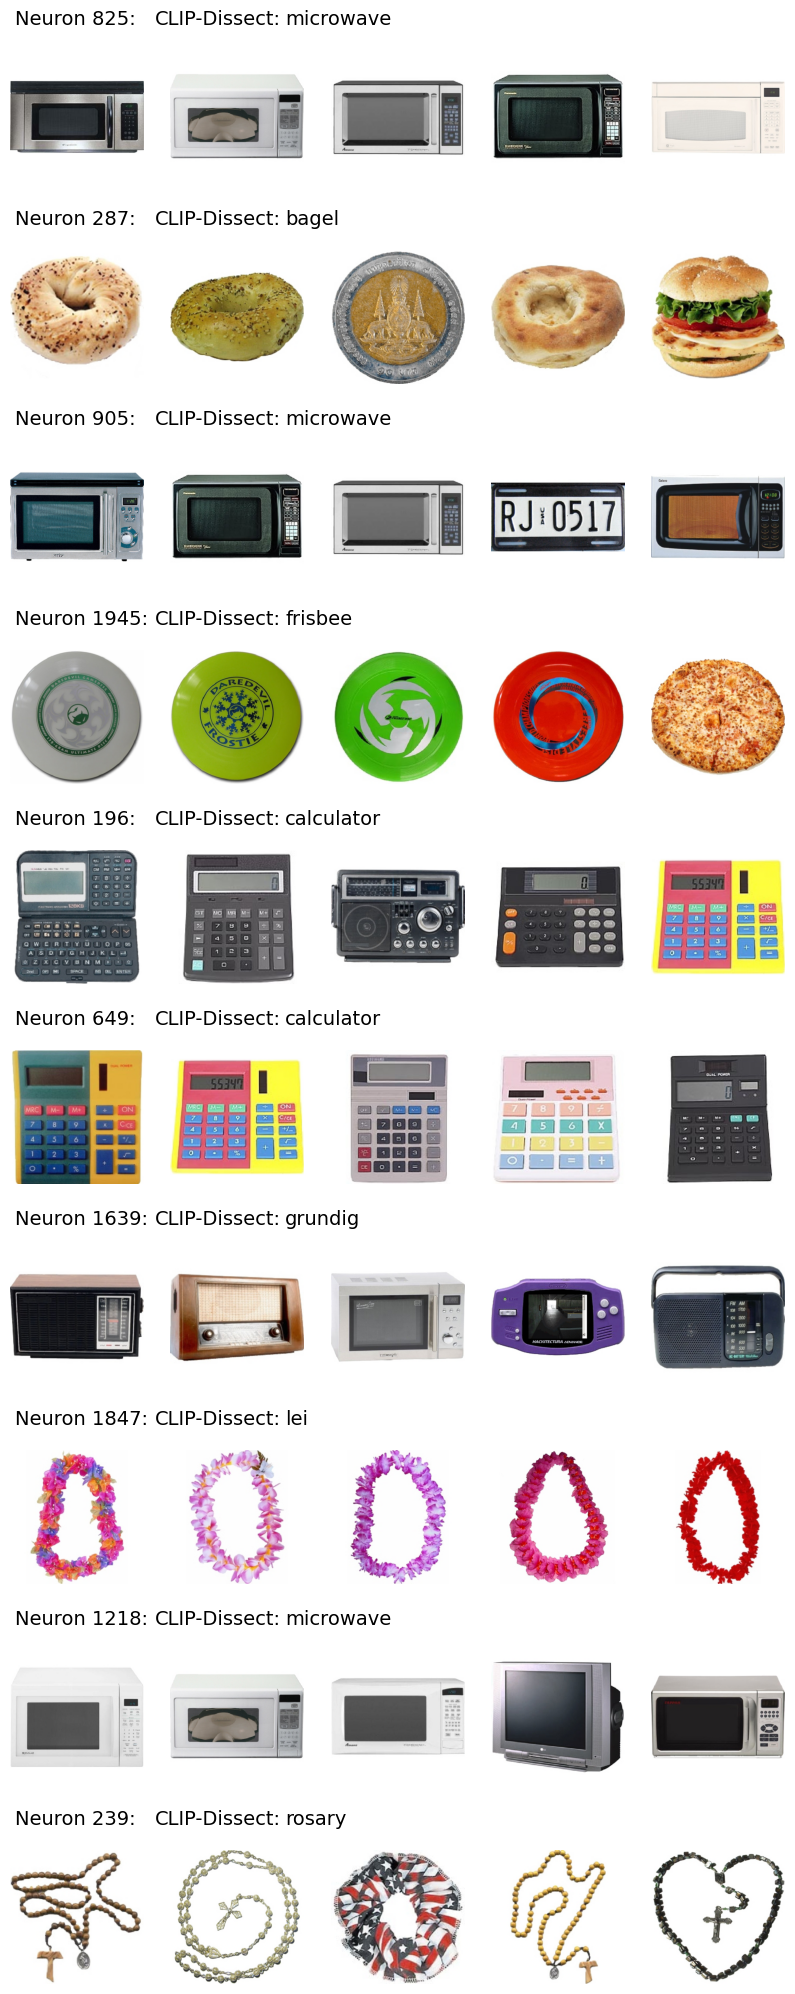

In [15]:
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

Base on Top Neuron Activation

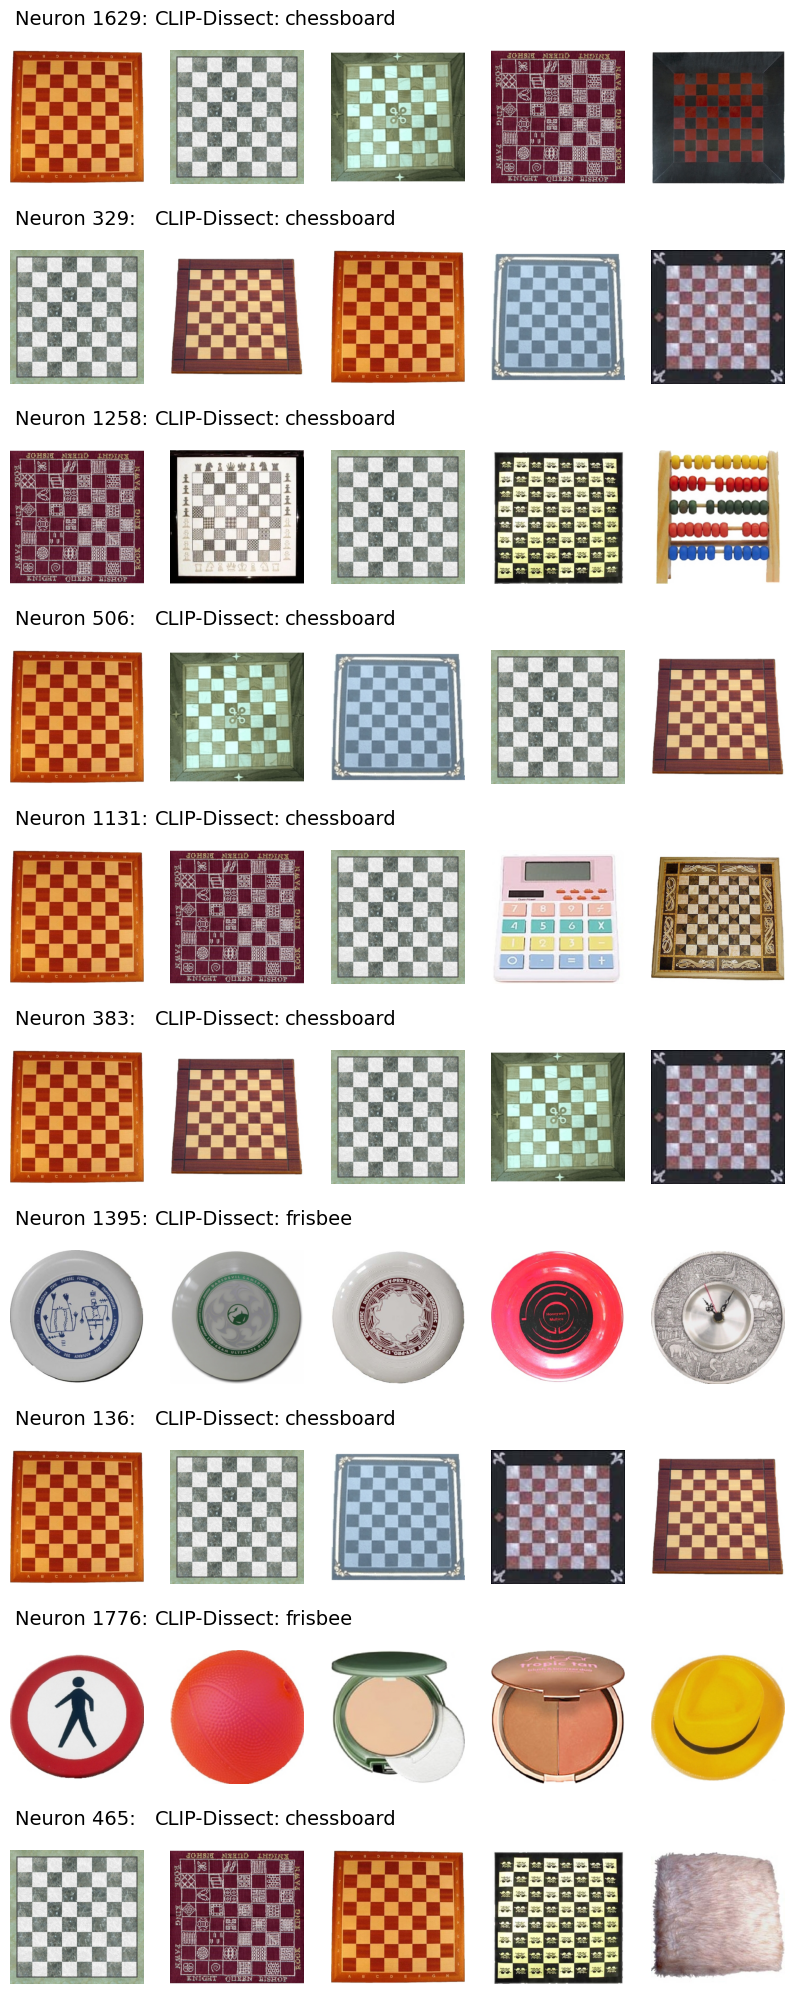

In [16]:
# ... existing code ...


top_activated_neurons = torch.sort(torch.max(target_feats, dim=0)[0], descending=True)[1][:10]
font_size = 14
font = {'size': font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(top_activated_neurons)*2])
subfigs = fig.subfigures(nrows=len(top_activated_neurons), ncols=1)
for j, neuron_id in enumerate(top_activated_neurons):
    vals, ids = torch.topk(similarities[neuron_id], k=5, largest=True)
    
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, f"Neuron {int(neuron_id)}:", size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, neuron_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

# ... existing code ...

In [9]:
# First part: Data collection
neurons_data = {}
neurons_to_check = {
    'vision_encoder.model.layer1': 47,
    'vision_encoder.model.layer2': 365,
    'vision_encoder.model.layer3': 36,
    'vision_encoder.model.layer4': 1776
}

# Collect data for each layer
for layer, neuron_id in neurons_to_check.items():
    save_names = utils.get_save_names(
        clip_name=clip_name, 
        target_name=target_name,
        target_layer=layer, 
        d_probe=d_probe,
        concept_set=concept_set, 
        pool_mode=pool_mode,
        save_dir=save_dir
    )
    
    target_save_name, clip_save_name, text_save_name = save_names
    similarities, target_feats = utils.get_similarity_from_activations(
        target_save_name, 
        clip_save_name, 
        text_save_name, 
        similarity_fn
    )
    
    # Store relevant data
    neurons_data[layer] = {
        'neuron_id': neuron_id,
        'top_images': torch.topk(target_feats, k=3, dim=0)[1][:, neuron_id],
        'label': words[int(torch.topk(similarities[neuron_id], k=1, largest=True)[1])]
    }



100%|██████████| 256/256 [00:01<00:00, 159.34it/s]


torch.Size([256, 30427])


100%|██████████| 512/512 [00:02<00:00, 188.23it/s]


torch.Size([512, 30427])


100%|██████████| 1024/1024 [00:05<00:00, 191.96it/s]


torch.Size([1024, 30427])


100%|██████████| 2048/2048 [00:09<00:00, 209.41it/s]


torch.Size([2048, 30427])


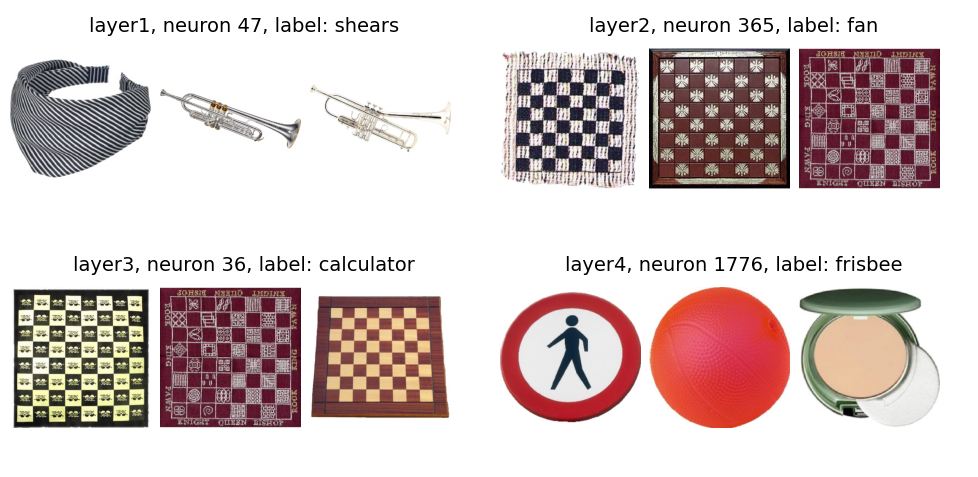

In [25]:
# Second part: Visualization (修改后的版本)
font_size = 14
font = {'size': font_size}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
layers = list(neurons_to_check.keys())
plt.tight_layout(h_pad=0.1,    # 垂直间距
                w_pad=0.1)   

for idx, (layer, data) in enumerate(neurons_data.items()):
    row = idx // 2
    col = idx % 2
    
    # Create a subplot for the current layer
    layer_name = layer.split('.')[-1]
    axs[row, col].text(0.5, 0.9, 
                      f"{layer_name}, neuron {data['neuron_id']}, label: {data['label']}", 
                      ha='center', 
                      transform=axs[row, col].transAxes)
    
    # Create a horizontal grid of 3 images
    for i, top_id in enumerate(data['top_images']):
        im, _ = pil_data[top_id]
        im = im.resize([375, 375])
        
        # Add subplot within the main subplot
        width = 0.3  # 原来是1/3 ≈ 0.33
        spacing = 0.32  # 控制图片起始位置的间隔
        x_start = i * spacing
        inner_ax = axs[row, col].inset_axes([x_start, 0, width, 1])
        inner_ax.imshow(im)
        inner_ax.axis('off')
    
    axs[row, col].axis('off')

plt.tight_layout()
plt.savefig('figures/suprious_examples.pdf', bbox_inches='tight', dpi=300)

plt.show()